# MODIS time series analysis using ARIMA

**Objectives:** To demonstrate the ARIMA application for time series analysis using MODIS data such as NDVI and EVI as an example.

If you want to know more of time seires analysis, please go to [here](https://otexts.com/fpp2/stationarity.html) for a detailed introduction. 


# Overview

## 1 download the MODIS data 
This step have been finished in R code using MODISTools packages. We get three variables for one region from 2000 to 2020: land cover, NDVI, EVI and corresponding quality layers.

## 2 Build a ARIMA model for modelling NDVI and EVI

Summary of major steps:

    1 Data quality check
    2 Data exploration and deal with low quality data
    3 Select the location with most high quality values using quality column
    4 Seasonal decomposition to see the trend, seasonal and residual distribution (visual check)
    5 Check Stationarity using augmented Dickey–Fuller test (ADF). H0 of ADF is non-stationary with unit root.
    6 Difference of time series data when the data is not stationary, which will determine the d in the model.
    7 Use ACF and PACF to determine whether we used AR or MA and corresponding paramters (p, q)
    8 There is a lot of model exploration to find a better paramters.
    

### Stationarity

#### what's stationarity?

Before we applied any model such as time series analysis for the data, we need to make sure our data are stationary, which is the model assumption.

Time series has a particular behaviour over time and there is a high probablity that it will follow te same pattern in the further. **It will have a (1)constant mean, (2)constant variance and (3)[autocovariance](https://smac-group.github.io/ts/fundtimeseries.html) (autocorrelation) that does not depend on time.** 

**Autocorrelation (or autocovariance)** is only a function of the lag between observations, rather than time itself.


A stationary time series is one whose properties do not depend on the time at which the series is [observed](https://otexts.com/fpp2/stationarity.html). Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Through checking the stationary, we can determine if we need to conduct data transformaton or not.



### How to make data become stationarity?

**1 Difference** can make a non-stationary time series stationary — compute the differences between consecutive observations. Differencing can help **stabilise the mean of a time series** by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

**2 Transformations** such as logarithms can help to stabilise the **variance** of a time series. 




## AR model
In an autoregression [model](https://otexts.com/fpp2/AR.html), we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

This is like a multiple regression but with lagged values of  yt as predictors. We refer to this as an AR(p) model, an autoregressive model of order p.

## MA model

Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like [model](https://otexts.com/fpp2/MA.html).

where εt is white noise. We refer to this as an MA(q) model, a moving average model of order q. Of course, we do not observe the values of εt, so it is not really a regression in the usual sense.

Notice that each value of yt can be thought of as a **weighted moving average of the past few forecast errors**.

###  Autocorrelation and Partial Autocorrelation to determine the MA and AR models

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    **how to determine p**: to see first negative values of PACF plot's corresponding x value
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    **how to determine q**: to see first negative values of ACF plot's corresponding x value
    
    

In [2]:
## import packages
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

In [3]:
dat = pd.read_csv("./data/new_ndvi_evi_qa_lc_nl_gelderland_loobos_2000_2020.csv")

## Data overview

In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502550 entries, 0 to 502549
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pixel       502550 non-null  int64  
 1   year        502550 non-null  int64  
 2   ndvi        502550 non-null  float64
 3   evi         502550 non-null  float64
 4   qa          502550 non-null  float64
 5   time        502550 non-null  object 
 6   land_cover  476100 non-null  float64
 7   lc_time     476100 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 30.7+ MB


In [5]:
dat.head()

,pixel,year,ndvi,evi,qa,time,land_cover,lc_time
0,1,2001,0.580022,0.229722,1.0,2001-01-01,7.0,2001-01-01
1,1,2001,0.586790,0.280697,0.0,2001-05-25,7.0,2001-01-01
2,1,2001,0.602963,0.265303,0.0,2001-05-09,7.0,2001-01-01
3,1,2001,0.699998,0.368226,0.0,2001-08-29,7.0,2001-01-01
4,1,2001,0.687665,0.339562,1.0,2001-06-10,7.0,2001-01-01


In [6]:
'''here each pixel represet one location and reprsent 250*250 region, 
we can see there are 465 time observations for each pixel'''

dat['pixel'].value_counts()

1023    437
333     437
76      437
332     437
588     437
       ... 
670     437
414     437
158     437
925     437
256     437
Name: pixel, Length: 1150, dtype: int64

## Data QA/AC

1 As we noticed, there is one layer called QA which include the quality information of the pixels at different time. we will first use them to conduct filtering.

2 if we have land cover type data, we can used that as a filter, we need to chose land cover type for vegetation from 1 to 10 and 12. You can refer to [here](https://lpdaac.usgs.gov/documents/101/MCD12_User_Guide_V6.pdf) for the land cover classification information

In [7]:
##filter based on quality information, it should be within 0 and 1
dat['qa'] = dat['qa'].apply(lambda x: x if x>=0 and x<=1 else None)

In [8]:
dat['land_cover'] = dat['land_cover'].apply(lambda x: x if x>=1 and x<=10 or x ==12 else None )

In [9]:
## filter based on land cover type if we have the information on this part
#dat['veg_or_not'] = dat[]

##  Data exploration

In [10]:
## 1 get year, month and day
dat['time'].nunique()

437

In [11]:
dat['date'] = pd.to_datetime(dat['time'])

In [12]:
dat.head()

,pixel,year,ndvi,evi,qa,time,land_cover,lc_time,date
0,1,2001,0.580022,0.229722,1.0,2001-01-01,7.0,2001-01-01,2001-01-01
1,1,2001,0.586790,0.280697,0.0,2001-05-25,7.0,2001-01-01,2001-05-25
2,1,2001,0.602963,0.265303,0.0,2001-05-09,7.0,2001-01-01,2001-05-09
3,1,2001,0.699998,0.368226,0.0,2001-08-29,7.0,2001-01-01,2001-08-29
4,1,2001,0.687665,0.339562,1.0,2001-06-10,7.0,2001-01-01,2001-06-10


In [13]:
###select several columns of interest to conduct analysis
scols = ['date','ndvi','evi','qa','pixel','land_cover'] ##here pixel represent the index of locations

df = dat[scols]

In [14]:
df.head()

,date,ndvi,evi,qa,pixel,land_cover
0,2001-01-01,0.580022,0.229722,1.0,1,7.0
1,2001-05-25,0.586790,0.280697,0.0,1,7.0
2,2001-05-09,0.602963,0.265303,0.0,1,7.0
3,2001-08-29,0.699998,0.368226,0.0,1,7.0
4,2001-06-10,0.687665,0.339562,1.0,1,7.0


In [15]:
df.set_index('date',inplace=True)

In [17]:
df.head()

,ndvi,evi,qa,pixel,land_cover
date,,,,,
2001-01-01,0.580022,0.229722,1.0,1,7.0
2001-05-25,0.586790,0.280697,0.0,1,7.0
2001-05-09,0.602963,0.265303,0.0,1,7.0
2001-08-29,0.699998,0.368226,0.0,1,7.0
2001-06-10,0.687665,0.339562,1.0,1,7.0


In [18]:
##scale the ndvi and evi
#df['ndvi'] = df['ndvi']/10000
#df['evi'] = df['evi']/10000

In [19]:
df.head()

,ndvi,evi,qa,pixel,land_cover
date,,,,,
2001-01-01,0.580022,0.229722,1.0,1,7.0
2001-05-25,0.586790,0.280697,0.0,1,7.0
2001-05-09,0.602963,0.265303,0.0,1,7.0
2001-08-29,0.699998,0.368226,0.0,1,7.0
2001-06-10,0.687665,0.339562,1.0,1,7.0


In [20]:
dd = df.groupby('pixel').count()

In [21]:
dd.head()

,ndvi,evi,qa,land_cover
pixel,,,,
1,437,437,387,414
2,437,437,380,414
3,437,437,387,414
4,437,437,380,414
5,437,437,387,414


In [27]:
#sel_pixel = dd['qa'].argmax()
sel_pixel = list(dd[dd['qa'] == dd['qa'].max()].index)

In [28]:
dd['land_cover'].max()

414

In [29]:
sel_pixel

[464]

### Visualize the Data

In [30]:
##one location or one pixel
sub_df = df[df['pixel']==sel_pixel[0]]
sub_df1 = sub_df.copy()

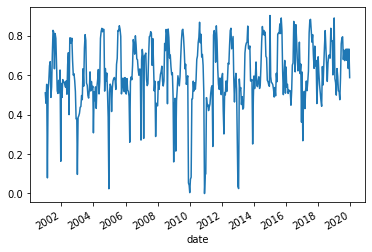

In [31]:
sub_df['ndvi'].plot()

### Low quality values

We can see that there are a lot of abnormal values or outliers.
Thus, we need to filter them ased on the QA column. 

There are two strategies to process these low quality or abnormal values

1 to remove them

2 to fill them with mean of previous and latter ones

In [32]:
## deal with low-quality values, to keep more data for following modelling, used second strategry
def lw_process(df,cols,qual_col = "qa",strategies = "fill"):
    for col in cols:
        if strategies != "fill":
            df[col] = df[df[qual_col].notnull()][col]
        else:
            df.loc[df[qual_col].isnull(),col] = None
            ##replace with neighbours
            df[col] = (df[col].fillna(method = 'ffill') + df['ndvi'].fillna(method = 'bfill'))/2
    return df        

In [33]:
date = sub_df.index

In [34]:
date

DatetimeIndex(['2001-08-13', '2001-12-03', '2001-09-30', '2001-04-23',
               '2001-07-28', '2001-04-07', '2001-09-14', '2001-02-02',
               '2001-07-12', '2001-05-25',
               ...
               '2019-07-28', '2019-08-13', '2019-08-29', '2019-09-14',
               '2019-09-30', '2019-10-16', '2019-11-01', '2019-11-17',
               '2019-12-03', '2019-12-19'],
              dtype='datetime64[ns]', name='date', length=437, freq=None)

In [35]:
sub_df.head()

,ndvi,evi,qa,pixel,land_cover
date,,,,,
2001-08-13,0.811592,0.659111,0.0,464,8.0
2001-12-03,0.626639,0.322690,1.0,464,8.0
2001-09-30,0.520509,0.298463,0.0,464,8.0
2001-04-23,0.668908,0.390804,1.0,464,8.0
2001-07-28,0.632686,0.279248,1.0,464,8.0


In [36]:
sub_ndf = lw_process(sub_df,cols = ['ndvi','evi'])

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [37]:
##check the results after preprocessing
sub_ndf[sub_ndf['qa'].isnull()]

,ndvi,evi,qa,pixel,land_cover
date,,,,,
2001-04-07,0.645467,0.462358,NaN,464,8.0
2001-02-18,0.745713,0.608782,NaN,464,8.0
2001-12-19,0.540692,0.403297,NaN,464,8.0
2002-06-26,0.568238,0.404007,NaN,464,8.0
2003-01-01,0.555652,0.433350,NaN,464,8.0
2003-08-13,0.675275,0.627638,NaN,464,8.0
2004-01-01,0.804617,0.645461,NaN,464,8.0
2004-12-18,0.662805,0.635807,NaN,464,8.0
2006-04-07,0.587502,0.449674,NaN,464,8.0


In [38]:
sub_df1[sub_df1['qa'].isnull()]

,ndvi,evi,qa,pixel,land_cover
date,,,,,
2001-04-07,0.648065,0.475009,NaN,464,8.0
2001-02-18,0.079125,0.101180,NaN,464,8.0
2001-12-19,0.163039,0.166622,NaN,464,8.0
2002-06-26,0.399989,0.280900,NaN,464,8.0
2003-01-01,0.096654,0.111121,NaN,464,8.0
2003-08-13,0.549531,0.411721,NaN,464,8.0
2004-01-01,0.307705,0.199380,NaN,464,8.0
2004-12-18,0.023811,0.030400,NaN,464,8.0
2006-04-07,0.259811,0.091611,NaN,464,8.0


In [39]:
timeseries = sub_ndf['ndvi']

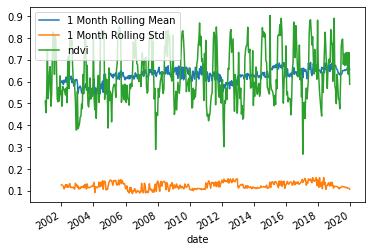

In [40]:
timeseries.rolling(23).mean().plot(label='1 Month Rolling Mean')
timeseries.rolling(23).std().plot(label='1 Month Rolling Std')
timeseries.plot()
plt.legend()

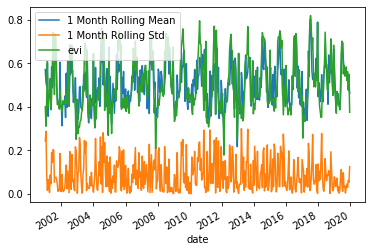

In [41]:
timeseries = sub_ndf['evi']
timeseries.rolling(2).mean().plot(label='1 Month Rolling Mean')
timeseries.rolling(2).std().plot(label='1 Month Rolling Std')
timeseries.plot()
plt.legend()

In [42]:
sub_ndf1 = sub_ndf.sort_index()

In [43]:
sub_ndf1.head()

,ndvi,evi,qa,pixel,land_cover
date,,,,,
2001-01-01,0.510641,0.398968,1.0,464,8.0
2001-01-17,0.457637,0.310024,1.0,464,8.0
2001-02-02,0.553835,0.434508,0.0,464,8.0
2001-02-18,0.745713,0.608782,NaN,464,8.0
2001-03-06,0.522178,0.401376,0.0,464,8.0


## Decomposition

ETS decomposition allows us to see the individual parts!

When we decompose a time series into components, we usually combine the trend and cycle into a single trend-cycle component (sometimes called the trend for simplicity). Thus we think of a time series as comprising three components: a trend-cycle component, a seasonal component, and a remainder component (containing anything else in the time series).

22 *16 is about one year. This is why we chose freq = 22

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

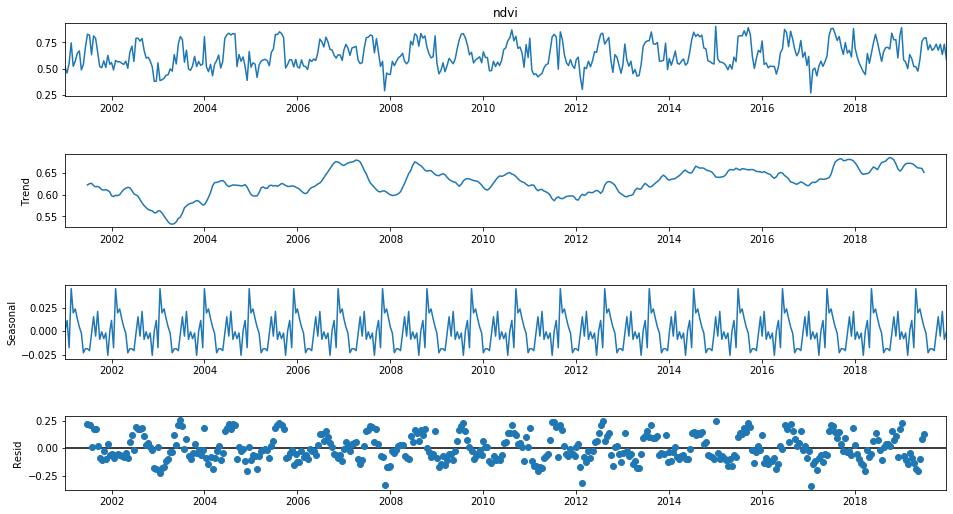

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sub_ndf1['ndvi'], 
                                   freq = 22)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Testing for Stationarity

An [augmented Dickey–Fuller test (ADF)](https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [45]:
from statsmodels.tsa.stattools import adfuller

In [46]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [47]:
timeseries = sub_ndf1['evi']

In [63]:
ts = timeseries.rolling(6).mean().dropna()

In [64]:
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.285804490640987
p-value : 0.17658718681656926
#Lags Used : 18
Number of Observations Used : 413
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [52]:
adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.065599884313892
p-value : 1.2988104990322564e-17
#Lags Used : 13
Number of Observations Used : 423
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## Important Note!

** We have now realized that our original data is stationary. But when we applied rolling mean, we can see the data become non-stationary.

If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data!

## Differencing -  if the data is not stationary

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

In [65]:
def difference(df,col,shift_num =1,level = 2):
    
    diff = df[col] - df[col].shift(1)
    diff.dropna(inplace = True)
    diff.plot()
    diff_level = 1
    re = adf_check(diff)
    
    while diff_level<level:
        diff = diff - diff.shift(shift_num)
        diff.dropna(inplace = True)
        diff.plot()
        re = adf_check(diff)
        diff_level +=1
        
    return re

Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.698091167542085
p-value : 1.5928044755113008e-21
#Lags Used : 18
Number of Observations Used : 417
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.59117846833706
p-value : 7.108189137985382e-09
#Lags Used : 18
Number of Observations Used : 397
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


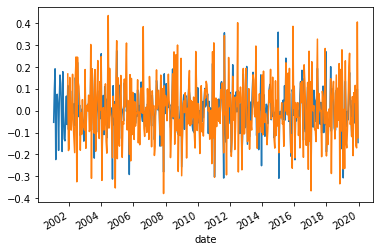

In [66]:
difference(sub_ndf1,col='ndvi',shift_num=20)

## Autocorrelation Interpretation

### use ACF and PACF to determine whether we used AR or MA

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

* If the **autocorrelation plot (ACF)** shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

In [71]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [72]:
ori_first = sub_ndf1['ndvi']

In [73]:
diff_first = sub_ndf1['ndvi'] - sub_ndf1['ndvi'].shift(1)

In [74]:
##one year is about 365/16
diff_season_first = sub_ndf1['ndvi'] - sub_ndf1['ndvi'].shift(22)

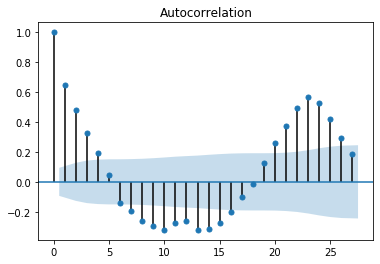

In [75]:
ori_first = plot_acf(ori_first)

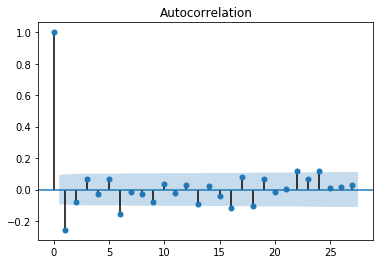

In [54]:
fig_first = plot_acf(diff_first.dropna())
##q here should be 1, it looks like difference =1 is enough

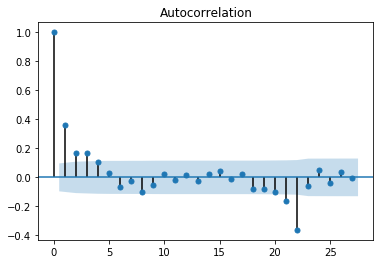

In [56]:
seasonal_fig_first = plot_acf(diff_season_first.dropna())

##when we used the seasonal one, it looks like we need to use MA term, q should be 6 for seasonal

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

## $\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}$

Check out this [link](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) for full details on this.

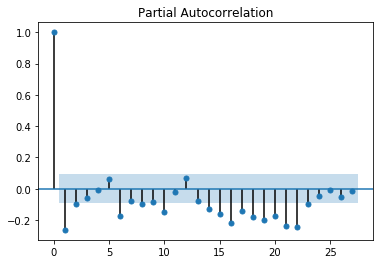

In [76]:
result = plot_pacf(diff_first.dropna())
##p should 1

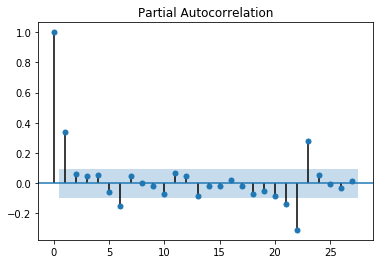

In [77]:
result = plot_pacf(diff_season_first.dropna())
##P SHOULD be 5 or 4

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

from the plot, we should use AR-2 model for seasonal

## Using the Seasonal ARIMA model

In [78]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

In [79]:
#help(ARIMA)

In [80]:
ts = sub_ndf1['ndvi']

In [83]:
model = ARIMA(ts,
              order = (1,1,0))
results = model.fit()
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ndvi   No. Observations:                  436
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 379.868
Method:                       css-mle   S.D. of innovations              0.101
Date:                Fri, 29 May 2020   AIC                           -753.735
Time:                        11:36:44   BIC                           -741.502
Sample:                             1   HQIC                          -748.907
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0003      0.004      0.071      0.944      -0.007       0.008
ar.L1.D.ndvi    -0.2634      0.046     -5.694      0.000      -0.354      -0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.7966           +0.0000j            3.7966            0.5000
-----------------------------------------------------------------------------
"""

In [82]:
model = ARIMA(ts,
              order = (2,1,0))
results = model.fit()
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ndvi   No. Observations:                  436
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 381.951
Method:                       css-mle   S.D. of innovations              0.101
Date:                Fri, 29 May 2020   AIC                           -755.902
Time:                        11:35:23   BIC                           -739.591
Sample:                             1   HQIC                          -749.465
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0003      0.003      0.078      0.938      -0.007       0.007
ar.L1.D.ndvi    -0.2888      0.048     -6.056      0.000      -0.382      -0.195
ar.L2.D.ndvi    -0.0977      0.048     -2.046      0.041      -0.191      -0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4789           -2.8378j            3.2000           -0.3265
AR.2           -1.4789           +2.8378j            3.2000            0.3265
-----------------------------------------------------------------------------
"""

In [87]:
model = ARIMA(ts,
              order = (2,1,1))
results = model.fit()
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ndvi   No. Observations:                  436
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 407.426
Method:                       css-mle   S.D. of innovations              0.095
Date:                Fri, 29 May 2020   AIC                           -804.851
Time:                        11:38:39   BIC                           -784.463
Sample:                             1   HQIC                          -796.805
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      1.402      0.161   -6.13e-05       0.000
ar.L1.D.ndvi     0.5761      0.048     12.073      0.000       0.483       0.670
ar.L2.D.ndvi     0.1034      0.048      2.163      0.031       0.010       0.197
ma.L1.D.ndvi    -1.0000      0.006   -171.179      0.000      -1.011      -0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3895           +0.0000j            1.3895            0.0000
AR.2           -6.9634           +0.0000j            6.9634            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [92]:
model = ARIMA(ts,
              order = (2,1,3))
results = model.fit()
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\tank\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\tank\AppData\Roaming\Python\Python37\site-

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ndvi   No. Observations:                  436
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 426.639
Method:                       css-mle   S.D. of innovations              0.090
Date:                Fri, 29 May 2020   AIC                           -839.278
Time:                        11:45:46   BIC                           -810.735
Sample:                             1   HQIC                          -828.014
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001   3.71e-05      4.008      0.000    7.59e-05       0.000
ar.L1.D.ndvi     1.7940      0.023     77.873      0.000       1.749       1.839
ar.L2.D.ndvi    -0.8689      0.022    -39.013      0.000      -0.913      -0.825
ma.L1.D.ndvi    -2.3384        nan        nan        nan         nan         nan
ma.L2.D.ndvi     1.7548        nan        nan        nan         nan         nan
ma.L3.D.ndvi    -0.4164        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0324           -0.2918j            1.0728           -0.0438
AR.2            1.0324           +0.2918j            1.0728            0.0438
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1813           +0.0000j            1.1813            0.0000
MA.3            2.0330           +0.0000j            2.0330            0.0000
-----------------------------------------------------------------------------
"""

In [107]:
model = ARIMA(ts,
              order = (5,1,4))
results = model.fit()
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\tank\Ana

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ndvi   No. Observations:                  436
Model:                 ARIMA(5, 1, 4)   Log Likelihood                 415.511
Method:                       css-mle   S.D. of innovations              0.092
Date:                Fri, 29 May 2020   AIC                           -809.022
Time:                        12:31:06   BIC                           -764.168
Sample:                             1   HQIC                          -791.321
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      1.349      0.177    -6.9e-05       0.000
ar.L1.D.ndvi    -0.6215      0.048    -12.919      0.000      -0.716      -0.527
ar.L2.D.ndvi    -0.3901      0.046     -8.561      0.000      -0.479      -0.301
ar.L3.D.ndvi    -0.1669      0.049     -3.421      0.001      -0.263      -0.071
ar.L4.D.ndvi     0.6913      0.046     15.055      0.000       0.601       0.781
ar.L5.D.ndvi     0.1445      0.048      3.034      0.002       0.051       0.238
ma.L1.D.ndvi     0.2107      0.012     16.892      0.000       0.186       0.235
ma.L2.D.ndvi     0.0002      0.013      0.017      0.987      -0.026       0.026
ma.L3.D.ndvi    -0.2112      0.012    -17.026      0.000      -0.236      -0.187
ma.L4.D.ndvi    -0.9997      0.013    -74.353      0.000      -1.026      -0.973
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0914           -1.0032j            1.0074           -0.2645
AR.2           -0.0914           +1.0032j            1.0074            0.2645
AR.3           -1.0224           -0.0000j            1.0224           -0.5000
AR.4            1.3525           -0.0000j            1.3525           -0.0000
AR.5           -4.9326           -0.0000j            4.9326           -0.5000
MA.1           -1.0003           -0.0000j            1.0003           -0.5000
MA.2           -0.1055           -0.9944j            1.0000           -0.2668
MA.3           -0.1055           +0.9944j            1.0000            0.2668
MA.4            1.0000           -0.0000j            1.0000           -0.0000
-----------------------------------------------------------------------------
"""

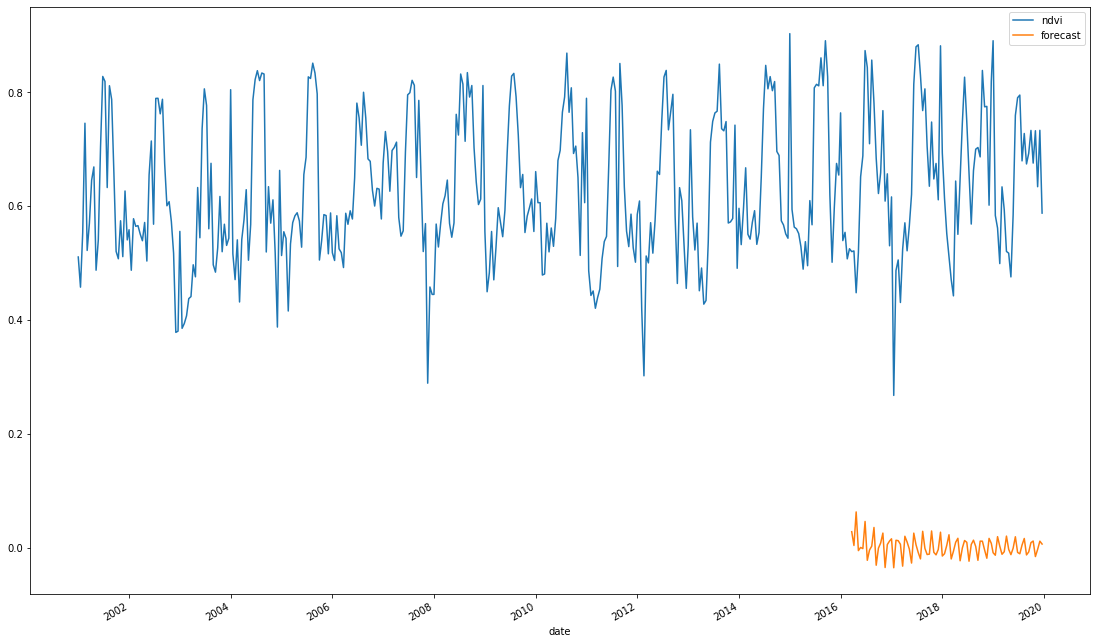

In [108]:
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

### visual check and evuation of the model

In [93]:
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  

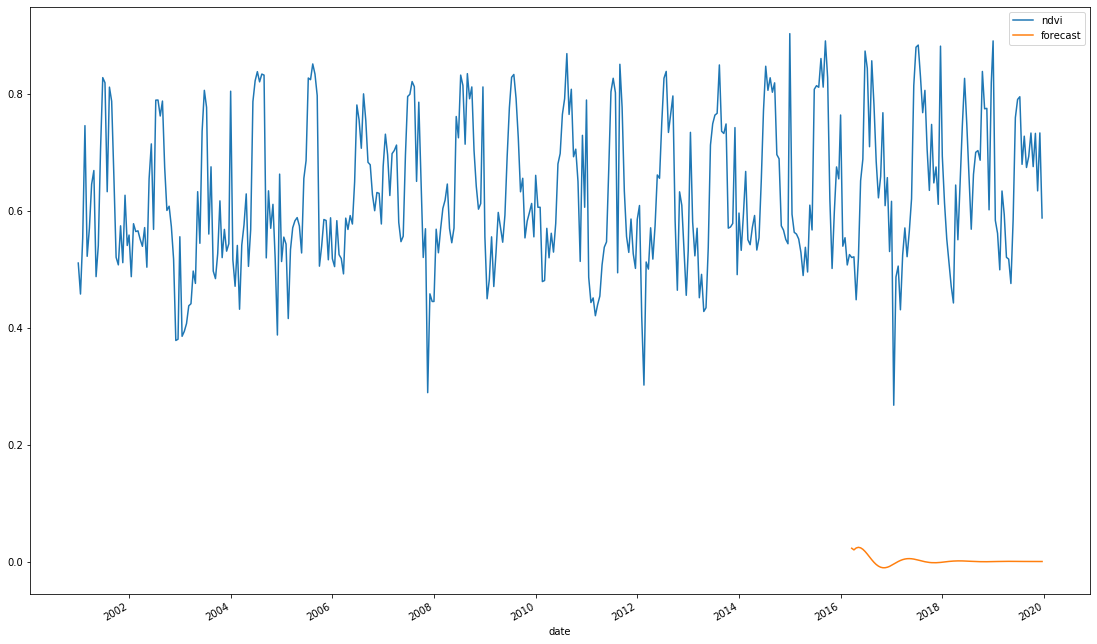

In [94]:
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

The result didn't looks good

Text(0.5, 1.0, 'RSS: 3.6187')

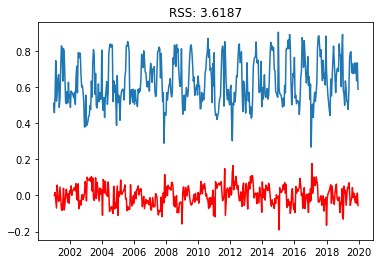

In [90]:
###Based on the exploration, we can see p =2, d=1 and q=3 is better choice in terms of AIC
plt.plot(ts)
plt.plot(results.fittedvalues,color='red')
diff = diff_first.dropna()
plt.title('RSS: %.4f'% sum((results.fittedvalues - diff)**2))

###  Seasonal ARIMA


In [79]:
#help(sm.tsa.statespace.SARIMAX)

In [95]:
##seasonal ARIMAX, we deterine p = 6, q=4 based on our pacf and acf 

model = sm.tsa.statespace.SARIMAX(ts,
                                  #order = (18,1,18), 
                                  seasonal_order = (2,1,3,18))
results = model.fit(disp= 1)
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                       ndvi   No. Observations:                  437
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2, 3], 18)   Log Likelihood                 360.840
Date:                                    Fri, 29 May 2020   AIC                           -707.679
Time:                                            11:48:13   BIC                           -679.414
Sample:                                                 0   HQIC                          -696.507
                                                    - 437                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6579      0.040     16.623      0.000       0.580       0.735
ar.S.L18      -1.0054      0.523     -1.924      0.054      -2.030       0.019
ar.S.L36      -0.9281      0.506     -1.833      0.067      -1.920       0.064
ma.S.L18       0.0057      2.737      0.002      0.998      -5.359       5.370
ma.S.L36      -0.0928      2.768     -0.034      0.973      -5.518       5.332
ma.S.L54      -0.9098      2.620     -0.347      0.728      -6.045       4.225
sigma2         0.0091      0.025      0.369      0.712      -0.039       0.057
===================================================================================
Ljung-Box (Q):                      157.92   Jarque-Bera (JB):                11.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.06
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

In [99]:
model = sm.tsa.statespace.SARIMAX(ts,
                                  #order = (18,1,18), 
                                  seasonal_order = (5,1,3,18))
results = model.fit(disp= 1)
results.summary()

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                       ndvi   No. Observations:                  437
Model:             SARIMAX(1, 0, 0)x(5, 1, [1, 2, 3], 18)   Log Likelihood                 371.068
Date:                                    Fri, 29 May 2020   AIC                           -722.136
Time:                                            11:57:05   BIC                           -681.757
Sample:                                                 0   HQIC                          -706.175
                                                    - 437                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5428      0.043     12.606      0.000       0.458       0.627
ar.S.L18      -0.0941      0.142     -0.664      0.507      -0.372       0.184
ar.S.L36      -0.8756      0.156     -5.602      0.000      -1.182      -0.569
ar.S.L54      -0.1198      0.152     -0.788      0.431      -0.418       0.178
ar.S.L72      -0.0619      0.126     -0.493      0.622      -0.308       0.184
ar.S.L90       0.1393      0.107      1.297      0.195      -0.071       0.350
ma.S.L18      -0.8569      0.139     -6.175      0.000      -1.129      -0.585
ma.S.L36       0.8735      0.145      6.018      0.000       0.589       1.158
ma.S.L54      -0.7374      0.122     -6.047      0.000      -0.976      -0.498
sigma2         0.0090      0.001     13.918      0.000       0.008       0.010
===================================================================================
Ljung-Box (Q):                       96.83   Jarque-Bera (JB):                13.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.06
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

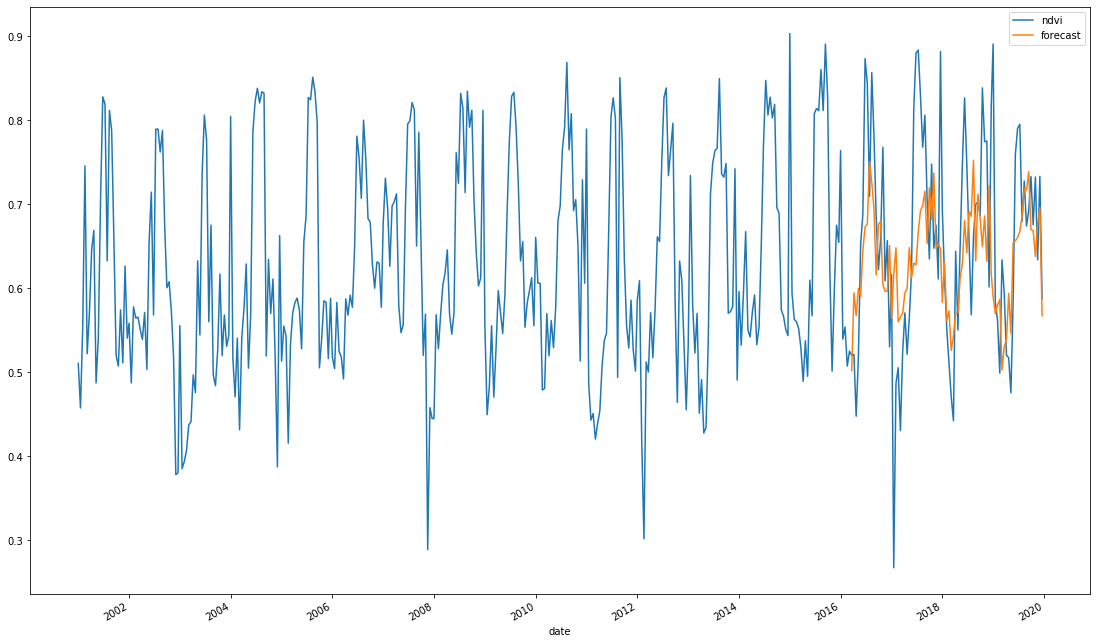

In [100]:
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle

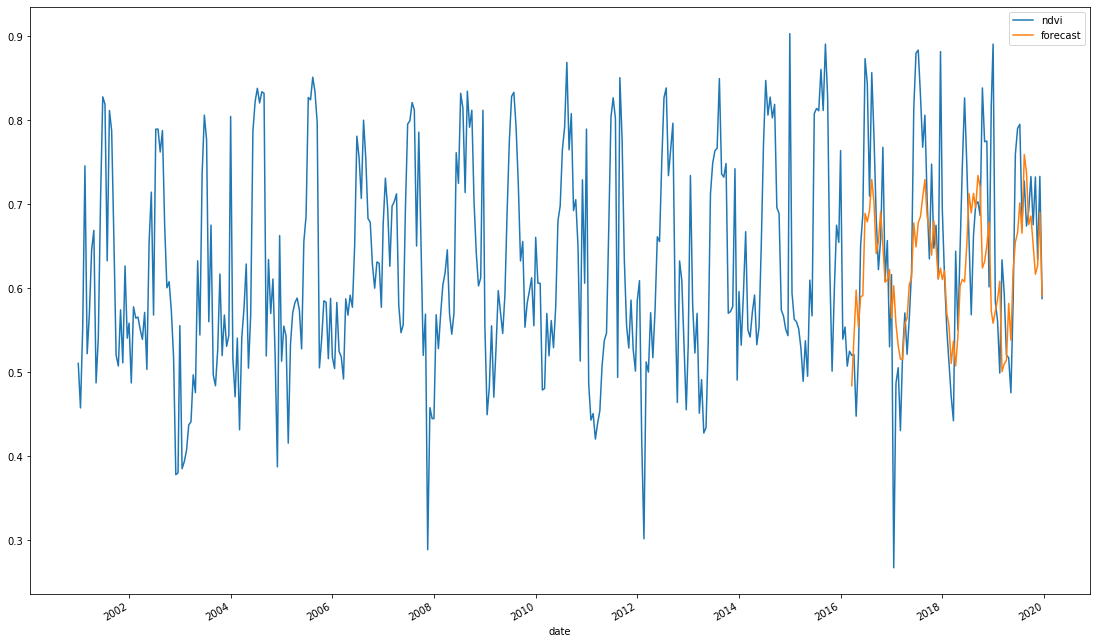

In [101]:
model = sm.tsa.statespace.SARIMAX(ts,
                                  #order = (18,1,18), 
                                  seasonal_order = (5,1,6,18))
results = model.fit(disp= 1)
results.summary()

##plot prediction
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

In [102]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                              SARIMAX Results                                              
===========================================================================================================
Dep. Variable:                                                ndvi   No. Observations:                  437
Model:             SARIMAX(1, 0, 0)x(5, 1, [1, 2, 3, 4, 5, 6], 18)   Log Likelihood                 378.562
Date:                                             Fri, 29 May 2020   AIC                           -731.124
Time:                                                     12:08:58   BIC                           -678.632
Sample:                                                          0   HQIC                          -710.375
                                                             - 437                                         
Covariance Type:                                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4948      0.044     11.134      0.000       0.408       0.582
ar.S.L18      -1.6550      2.631     -0.629      0.529      -6.811       3.501
ar.S.L36      -1.6559      3.515     -0.471      0.638      -8.545       5.233
ar.S.L54      -1.8007      3.087     -0.583      0.560      -7.850       4.249
ar.S.L72      -1.2765      3.659     -0.349      0.727      -8.447       5.894
ar.S.L90      -0.3154      2.057     -0.153      0.878      -4.347       3.716
ma.S.L18       0.5718      5.156      0.111      0.912      -9.533      10.676
ma.S.L36      -0.0765      5.578     -0.014      0.989     -11.009      10.856
ma.S.L54       0.1560      4.765      0.033      0.974      -9.182       9.494
ma.S.L72      -0.4888      5.885     -0.083      0.934     -12.023      11.045
ma.S.L90      -0.8393      3.492     -0.240      0.810      -7.683       6.005
ma.S.L108     -0.3162      1.602     -0.197      0.844      -3.455       2.823
sigma2         0.0076      0.026      0.298      0.765      -0.043       0.058
===================================================================================
Ljung-Box (Q):                       73.50   Jarque-Bera (JB):                35.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.04
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


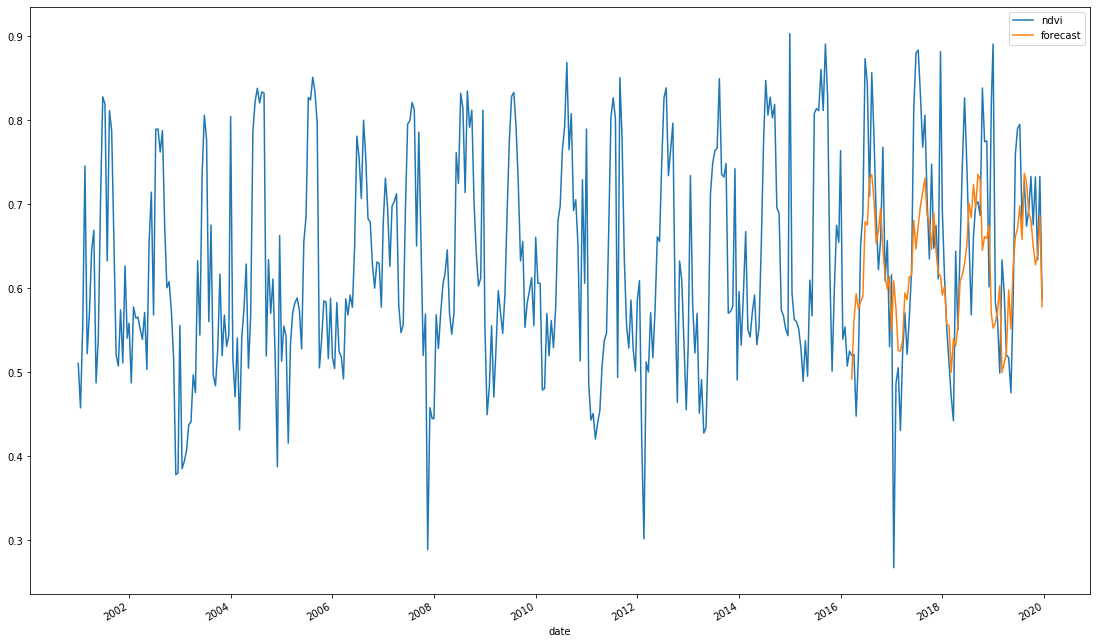

In [103]:
###this is the best model so far

model = sm.tsa.statespace.SARIMAX(ts,
                                  #order = (18,1,18), 
                                  seasonal_order = (5,1,4,18))
results = model.fit(disp= 1)
results.summary()

##plot prediction
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

In [104]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                          ndvi   No. Observations:                  437
Model:             SARIMAX(1, 0, 0)x(5, 1, [1, 2, 3, 4], 18)   Log Likelihood                 378.230
Date:                                       Fri, 29 May 2020   AIC                           -734.460
Time:                                               12:16:02   BIC                           -690.043
Sample:                                                    0   HQIC                          -716.903
                                                       - 437                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5176      0.042     12.434      0.000       0.436       0.599
ar.S.L18      -0.5867      0.229     -2.563      0.010      -1.035      -0.138
ar.S.L36      -0.5455      0.164     -3.330      0.001      -0.866      -0.224
ar.S.L54      -0.8040      0.262     -3.063      0.002      -1.318      -0.290
ar.S.L72       0.0304      0.135      0.226      0.821      -0.233       0.294
ar.S.L90       0.1540      0.099      1.553      0.120      -0.040       0.348
ma.S.L18      -0.4486      0.264     -1.698      0.089      -0.966       0.069
ma.S.L36       0.0395      0.281      0.141      0.888      -0.511       0.590
ma.S.L54       0.2916      0.290      1.004      0.315      -0.278       0.861
ma.S.L72      -0.7738      0.242     -3.193      0.001      -1.249      -0.299
sigma2         0.0080      0.001     10.588      0.000       0.006       0.009
===================================================================================
Ljung-Box (Q):                       77.22   Jarque-Bera (JB):                32.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.07
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\tank\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


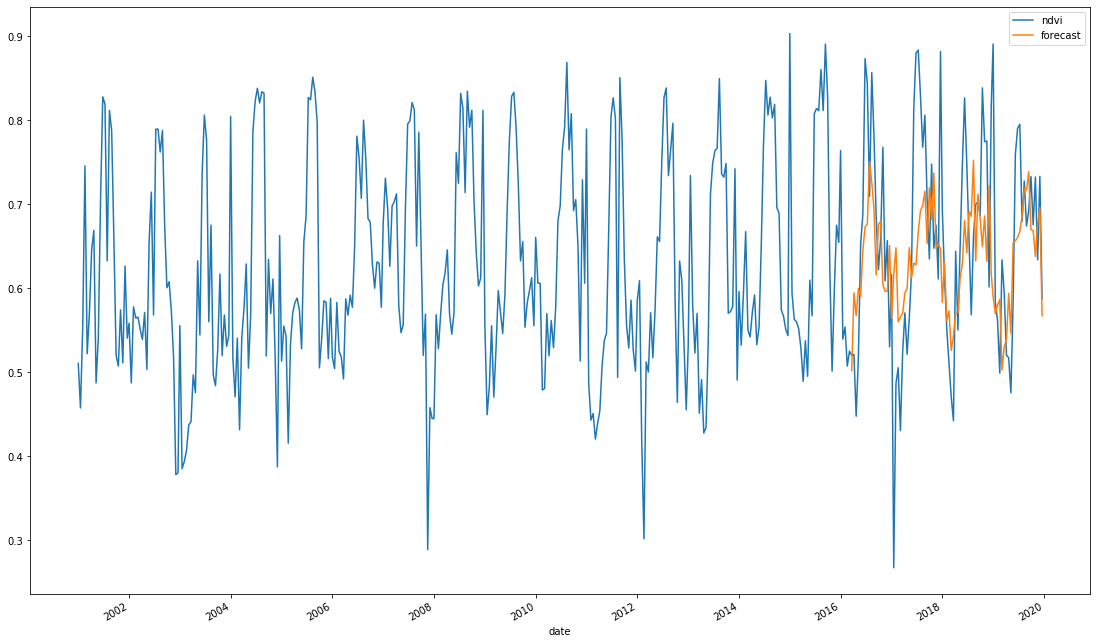

In [105]:
model = sm.tsa.statespace.SARIMAX(ts,
                                  #order = (18,1,18), 
                                  seasonal_order = (5,1,3,18))
results = model.fit(disp= 1)
results.summary()

##plot prediction
sub_ndf1['forecast'] = results.predict(start = 350, 
                                 end = 436, 
                                 dynamic = True)  
sub_ndf1[['ndvi','forecast']].plot(figsize = (19, 12))

In [106]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                       ndvi   No. Observations:                  437
Model:             SARIMAX(1, 0, 0)x(5, 1, [1, 2, 3], 18)   Log Likelihood                 371.068
Date:                                    Fri, 29 May 2020   AIC                           -722.136
Time:                                            12:23:18   BIC                           -681.757
Sample:                                                 0   HQIC                          -706.175
                                                    - 437                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5428      0.043     12.606      0.000       0.458       0.627
ar.S.L18      -0.0941      0.142     -0.664      0.507      -0.372       0.184
ar.S.L36      -0.8756      0.156     -5.602      0.000      -1.182      -0.569
ar.S.L54      -0.1198      0.152     -0.788      0.431      -0.418       0.178
ar.S.L72      -0.0619      0.126     -0.493      0.622      -0.308       0.184
ar.S.L90       0.1393      0.107      1.297      0.195      -0.071       0.350
ma.S.L18      -0.8569      0.139     -6.175      0.000      -1.129      -0.585
ma.S.L36       0.8735      0.145      6.018      0.000       0.589       1.158
ma.S.L54      -0.7374      0.122     -6.047      0.000      -0.976      -0.498
sigma2         0.0090      0.001     13.918      0.000       0.008       0.010
===================================================================================
Ljung-Box (Q):                       96.83   Jarque-Bera (JB):                13.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.06
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""